In [16]:
import numpy as np
from numpy import array, sin, cos, dot, random, zeros, ones, exp
from scipy.optimize import minimize, root
from scipy.linalg import solve, norm
from scipy.integrate import simps
from scipy.interpolate import lagrange
from math import pi
import sys
import matplotlib.pyplot as plt
from matplotlib import animation,rc
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt

## Mechanical System

In [28]:
#change here
#------------
Duration = 1;
FPS = 100;
starting_point = array([0.001,0,0,0])
#-----------
dt = 1./FPS
N = int(Duration*FPS);

def acrobot_gradient(x, u):
    friction = 2
    g = 9.8
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) + 2*g*sin(x[0]) + g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) + g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    B = np.concatenate([[0,0],solve(M,array([0,1]))])
    xd = a + B*u
    return xd

def acrobot_next_step(x,u):
    
    xd = acrobot_gradient(x,u)
    new_x = x + xd*dt
    #limit angle range to [0,2 pi]
    new_x[0]%=(2*pi)
    new_x[1]%=(2*pi)
    #avoid acceleration overflow
    return np.clip(new_x,-100,100)
#r=k=1
#cost_function = lambda x,u,r,k : r/2*u**2 + 1 - exp(k*cos(x[0]) + k*cos(x[1])-2*k)
#cost_function = lambda x,u : u**2 + dot(x,x)

## Lagrangian Bruteforce

In [5]:
#brute force method, not converging

def lagrangian(input_array):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
    x = np.concatenate([[pi,0,0,0],input_array[:(N-1)*4]])
    u = input_array[(N-1)*4:(N-1)*4+N]
    lam = input_array[(N-1)*4+N:-1]

    L=0
    for i in range(N-1):
        #current x
        xx = x[i*4:(i+1)*4]
        #next x
        xx_p1 = x[(i+1)*4:(i+2)*4]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_motion(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i])
        lagragian_term = lam[i]*(delta[0:1]%(2*pi))
        L+=cost+lagragian_term
    return L
def lagrangian_train():
    init = np.ones(N*4+N+N)
    out = minimize(lagrangian,init)

## Lagrangian multiplier derivation

In [9]:
def grad_lagrangian_trick(u):
    # u is a vector of u0 to uN-1
    n=len(u)
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    dldu = zeros(n)
    
    #define partial derivation functions
    def dgdx(x,u):
        k=1
        out = zeros(4)
        x1= x[0]
        x2= x[1]
        out[0] = exp(k*cos(x1)+k*cos(x1)-2*k)*k*sin(x1)
        out[1] = exp(k*cos(x2)+k*cos(x2)-2*k)*k*sin(x2)
        return out
    dgdu = lambda x,u : 0
    
    delta = 0.0001
    def dfdxT(x,u):
        out = zeros([4,4])
        for i in range(4):
            delta_v = zeros(4)
            delta_v[i] = delta
            #print(x+delta_v)
            out[i] = ((acrobot_gradient(x+delta_v,u)-acrobot_gradient(x-delta_v,u))*dt+2*delta_v)/2/delta
        return out
    dfdu = lambda x,u : ((acrobot_gradient(x,u+delta)-acrobot_gradient(x,u-delta))*dt+2*delta)/2/delta
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i])+dot(dfdxT(x[i],u[i]),lam[i])
    
    for i in range(n):
        dldu[i]=dgdu(x[i],u[i])+dot(lam[i],dfdu(x[i],u[i]))
    
    return dldu

def lagrangian_train(dt,N):
    u = zeros(N)#random.normal(0,size=N)
    out = root(grad_lagrangian_trick,u) 
    return (out,out.x)

## Chebyshev

In [10]:
def interpolate_fit(x, coef):
    f = lambda x : sum([pow(x, y)*coef[y] for y in range(len(coef))])
    vfunc = np.vectorize(f)
    return vfunc(x)

def chebyshev_gradient(ts,order,cheby_t,cheby_u):
    def interpolate_grad_fit(x, cheby_t, cheby_u):
        # fit gradient of model relate to cheby u
        # dL(t)dwj = lj(t) = (x-x0)/(xj-x0)....x-xk)/(xj-xk)
        f = lambda x : array(
            [
                np.prod([
                    (x-xi)/(xj-xi) 
                    for xi in cheby_t if xi!=xj
                ]) 
                for xj in cheby_t
            ]
        )
        return array([f(xx) for xx in x])
    #calculate u according to current chebyshev
    poly = np.flipud(lagrange(cheby_t,cheby_u))
    u = interpolate_fit(ts, poly)
    # calculate dLdw
    dldu = grad_lagrangian_trick(u)
    dudw = interpolate_grad_fit(ts, cheby_t, cheby_u)
    return array([simps(dudw[:,i]*dldu,ts) for i in range(order)])

def chebyshev_train(dt,N,order):
    chebyshev = lambda n: array([cos((2*j-1)*pi/(2*n)) for j in range(1,n+1)])
    Duration = N*dt
    ts = np.arange(N)*dt
    cheby_t = (chebyshev(order)+1)*Duration/2
    cheby_u = random.normal(0,size=order)
    
    local_chebyshev_gradient = lambda cheby_u: chebyshev_gradient(ts,order,cheby_t,cheby_u)
    out = root(local_chebyshev_gradient,cheby_u)
    
    #get final u array
    poly = np.flipud(lagrange(cheby_t,out.x))
    u = interpolate_fit(ts, poly)
    return (out,u)

## Fit

In [29]:
out = chebyshev_train(dt,N,10) 
#out = lagrangian_train(dt,N)
u = out[1]

## Simulation

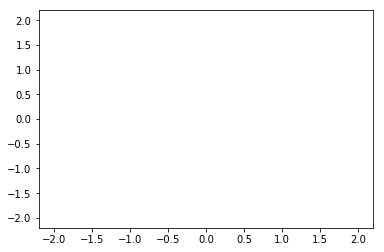

In [30]:

x = np.zeros((N, 4))
x[0] = starting_point
for i in range(N-1):
    x[i+1] = x[i] + dt*acrobot_gradient(x[i], u[i])
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(k):
    x1 = cos(x[k,0]+pi/2);
    y1 = sin(x[k,0]+pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]+pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]+pi/2);
    
    xs = [0, x1, x2]
    ys = [0, y1, y2]
    line.set_data(xs, ys)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)


In [ ]:
HTML(anim.to_html5_video())

## Plot

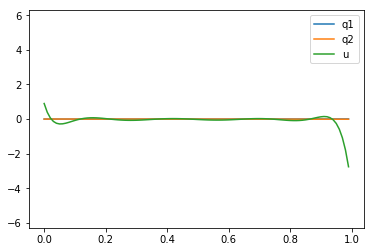

In [31]:
ts = np.arange(N)*dt
plt.plot(ts,x[:,0],label="q1")
plt.plot(ts,x[:,1],label="q2")
plt.plot(ts,u,label="u")
plt.legend()
plt.ylim([-2*pi,2*pi])
plt.show()

# test codes, will delete in the end


First, we add frictions to the system:

$Bu = B\hat{u}-f\dot{q}$

So that:

$H(q)\ddot{q}+C(q,\dot{q})\dot{q}+G(q)=B\hat{u}-f\dot{q}$

Afterward, $\ddot{q}$ can be calculated as:

$\ddot{q}=H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)+B\hat{u}-f\dot{q}]$

$\ddot{q}=H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)-f\dot{q}]+H(q)^{-1}B\hat{u}$

Thus,

$\dot{x} = \begin{bmatrix} \dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2} \end{bmatrix} = \begin{bmatrix} \dot{q_1} \\ \dot{q_2} \\ H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)-f\dot{q}] \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ H(q)^{-1}B \end{bmatrix}\hat{u}$

After setting all constants to 1, the system can be simplified so that:

$H(q) = \begin{bmatrix} 3+2cos(q_2) & 1+cos(q_2) \\ 1+cos(q_2) & 1 \end{bmatrix}$

$C(q,\dot{q})\dot{q}-G(q) = \begin{bmatrix} \dot{q_2}(2\dot{q_1}+\dot{q_2})sin(q_2)+2g sin(q_1)+gsin(q_1+q_2) \\ -\dot{q_1}^2-sin(q_2)+gsin(q_1+q_2) \end{bmatrix}$

In [26]:
x[:,0]

array([  1.00000000e-03,   1.00000000e-03,  -5.43982810e-02,
        -1.50418812e-01,  -2.70093541e-01,  -3.90606560e-01,
        -4.97936427e-01,  -5.90470588e-01,  -6.69707684e-01,
        -7.36891379e-01,  -7.92679857e-01,  -8.37319077e-01,
        -8.70898224e-01,  -8.93679686e-01,  -9.06519957e-01,
        -9.11284699e-01,  -9.10962374e-01,  -9.09136063e-01,
        -9.08925680e-01,  -9.12125915e-01,  -9.19101956e-01,
        -9.29252067e-01,  -9.41548391e-01,  -9.54902440e-01,
        -9.68347698e-01,  -9.81109479e-01,  -9.92620870e-01,
        -1.00251712e+00,  -1.01062260e+00,  -1.01693515e+00,
        -1.02160899e+00,  -1.02493625e+00,  -1.02732742e+00,
        -1.02929102e+00,  -1.03141278e+00,  -1.03433388e+00,
        -1.03872696e+00,  -1.04526684e+00,  -1.05459186e+00,
        -1.06725108e+00,  -1.08363335e+00,  -1.10387952e+00,
        -1.12778917e+00,  -1.15474845e+00,  -1.18371911e+00,
        -1.21332507e+00,  -1.24204022e+00,  -1.26842927e+00,
        -1.29135992e+00,